In [1]:
import random
import bittensor as bt
from transformers import GPT2LMHeadModel
from common import *

/home/ubuntu/frontend/cont/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

# Init.
n = 2
compression = 100
models = [GPT2LMHeadModel(GPT2LMHeadModel.config_class()) for _ in range( n )]

for i in range( n ):
    wallet = bt.wallet(hotkey=f'M{i}')
    if not wallet.hotkey_file.exists_on_device():
        bt.wallet(hotkey=f'M{i}').create_if_non_existent()

window = random.randint(0, 1000000000)
indices = await get_indices_for_window(
    model = models[0], 
    seed = window, 
    compression = compression
)

for i in range( n ):
    await upload_slice_for_window(
        bucket = 'decis', 
        model = models[i], 
        window = window, 
        seed = window, 
        wallet = bt.wallet(hotkey=f'M{i}'), 
        compression = compression
    )

slice_infos = (await download_slices_for_buckets_and_windows(
    buckets = ['decis'], 
    windows = [window]
))[window]

for i in range( n ):
    await apply_slices_to_model( model = models[i], window = window, seed = window, compression = compression)

# Assert all values in all models under indices Dict[name, indices] match
for name, param in models[0].named_parameters():
    if name in indices:
        param_indices = indices[name].to(param.data.device)
        base_values = param.data.view(-1)[param_indices]
        for model in models[1:]:
            model_param_values = model.state_dict()[name].view(-1)[param_indices]
            assert torch.equal(base_values, model_param_values), f"Values for {name} do not match across models"
print('All values match across all models')
        



All values match across all models


In [4]:
import torch
import time
import sys
import random
import hashlib
import numpy as np
from tqdm import tqdm
import torch.optim as optim
from dataset import AsyncSubsetFineWebEdu2Loader  # Custom dataset module
from transformers import GPT2LMHeadModel, AutoTokenizer
import asyncio
import logging
import matplotlib.pyplot as plt
import pandas as pd
import bittensor as bt
from common import *

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

/home/ubuntu/frontend/cont/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:

async def run_sim( window: int, models, optimizers, tokenizer, compression):
    """
    Run a simulation step to compute cosine similarities between miner updates and base model gradients.

    Args:
        models (list of nn.Module): List of miner models.
        optimizers (list of Optimizer): List of optimizers for the miner models.
        tokenizer (Tokenizer): Tokenizer used for the models.

    Returns:
        similarity (list of float): List of total cosine similarities for each miner model.
    """
    
    # First get the window.
    base_model = models[0]
    indices = await get_indices_for_window(
        model = base_model, 
        seed = window, 
        compression = compression
    )
    for name, idx in indices.items():
        idx.to(base_model.device)
    
    # Next average all miners on window.
    print (f'Upload slices for window: {window}')
    for i, model_i in enumerate(models):
        await upload_slice_for_window(
            bucket = 'decis', 
            model = model_i, 
            window = window, 
            seed = window, 
            wallet = bt.wallet(hotkey=f'M{i}'), 
            compression = compression
        )

    # Next download slices for this window.
    print (f'Download slices for window: {window}')
    slice_infos = (await download_slices_for_buckets_and_windows(
        buckets = ['decis'], 
        windows = [window]
    ))[window]
    print (f'Downloaded {len(slice_infos)} slices')

    # Apply slices to the models to ensure they all have the same state.
    print (f'Apply slices for window: {window}')
    for i, model_i in enumerate(models):
        await apply_slices_to_model( model = model_i, window = window, seed = window, compression = compression)

    # Assert all values in all models under indices Dict[name, indices] match
    print (f'Assert all miners have same state on window: {window}')
    for name, param in base_model.named_parameters():
        if name in indices:
            param_indices = indices[name].to(param.data.device)
            base_values = param.data.view(-1)[param_indices]
            for model_i in models:
                model_param_values = model_i.state_dict()[name].view(-1)[param_indices]
                assert torch.equal(base_values, model_param_values), f"Values for {name} do not match across models"
    print('All values match across all models')

    # Training phase for miner models
    print (f'Train models for window: {window}')
    for i, model_i in enumerate(models[1:]):
        # Get page for miner model and window.
        pages = await AsyncSubsetFineWebEdu2Loader.next_pages(
            offset = window,
            n_pages = 1,
            seed = i
        )
        dataset = await AsyncSubsetFineWebEdu2Loader.create(
            batch_size = 2,
            sequence_length = 1024,
            pages_info = pages,
            tokenizer = tokenizer
        )
        
        # Train the miner model on its dataset
        model_i.zero_grad()
        for batch in tqdm(dataset):
            input_ids = torch.tensor(batch, dtype=torch.long).to(models[i].device)
            labels = input_ids.clone()
            labels = torch.where(labels == tokenizer.pad_token_id, -100, labels)
            with torch.amp.autocast(device_type=model_i.device.type, dtype=torch.bfloat16):
                outputs = model_i(input_ids=input_ids, labels=labels)
            outputs.loss.backward()
        optimizers[i+1].step()
        optimizers[i+1].zero_grad()

    # Validation phase: compute similarities
    similarity = []
    divergence = []
    for i, model_i in tqdm( enumerate(models[1:]), desc="Evalling miners"):
        # Decide whether to use a random page or the same page the miner trained on
        is_random = True if i % 2 != 0 else False
        seed = random.randint(0, 10000) if is_random else i
        pages = await AsyncSubsetFineWebEdu2Loader.next_pages(
            offset=window,
            n_pages=1,
            seed=seed
        )
        dataset = await AsyncSubsetFineWebEdu2Loader.create(
            batch_size=2,
            sequence_length=1024,
            pages_info=pages,
            tokenizer=tokenizer
        )
        # Compute gradients on the base model
        base_model.zero_grad()
        for batch in dataset:
            input_ids = torch.tensor(batch, dtype=torch.long).to(base_model.device)
            labels = input_ids.clone()
            labels = torch.where(labels == tokenizer.pad_token_id, -100, labels)
            with torch.amp.autocast(device_type=base_model.device.type, dtype=torch.bfloat16):
                outputs = base_model(input_ids=input_ids, labels=labels)
            outputs.loss.backward()

        # Compute cosine similarity between the miner's update and the base model's gradient
        total_sim = 0.0
        total_divergence = 0.0
        for name, param in base_model.named_parameters():
            if param.grad is None:
                continue  # Skip parameters without gradients
            
            # Get indices for this param.
            idxs = indices[name].clone().detach().to(base_model.device)

            # Get the gradient from the base model
            g = param.grad.view(-1).clone().detach().to(base_model.device)

            # Get the parameter difference (delta) between the miner model and the base model
            p1 = model_i.state_dict()[name].view(-1).clone().detach().to(base_model.device)
            p2 = param.data.view(-1).clone().detach().to(base_model.device)
            delta = p1 - p2

            # Compute the cosine similarity between delta and gradient
            sim = torch.nn.functional.cosine_similarity(-delta[idxs], g[idxs], dim=0).item()
            weight = p1.data.view(-1)[idxs].norm().item() + 1e-8
            total_sim += weight * sim
            total_divergence += delta[idxs].norm().item()
        
        # Log the similarity result
        logger.info(f'Model {i}, is_random: {is_random}, total_sim: {total_sim}, total_divergence: {total_divergence}')
        similarity.append(total_sim)
        divergence.append( total_divergence )

    # Return the similarities
    return similarity, divergence

In [6]:
async def main(n_steps:int = 2 , n_miners: int = 2, device: str = 'cuda:4', compression:int = 1):
    """
    Main function to run the simulation over multiple steps.
    """
    # Load the miner models
    logger.info("Loading miner models...")
    models = [GPT2LMHeadModel.from_pretrained('gpt2').to(device) for _ in range(n_miners + 1)]

    # Create optimizers for miner models
    optimizers = []
    for i, model_i in enumerate(models):
        optimizers.append(optim.AdamW(
            model_i.parameters(),
            lr=5e-5,  # Peak learning rate
            betas=(0.9, 0.95),  # B1 and B2
            weight_decay=0.1,  # Weight decay
            foreach=True,  # More memory usage, but faster
        ))

    # Load the tokenizer
    logger.info("Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained('gpt2', verbose=False, clean_up_tokenization_spaces=True)
    tokenizer.pad_token = tokenizer.eos_token  # Set pad token

    # Run the simulation for multiple steps
    results = []
    div_results = []
    for step in range(n_steps):
        logger.info(f"Starting simulation step {step+1}/{n_steps}...")
        sim, div = await run_sim( window = step, models, optimizers, tokenizer, compression)
        results.append(sim)
        div_results.append(div)
        
    # After simulation, process and plot the results
    logger.info("Simulation completed. Processing results...")

    # Process similarity results into DataFrame
    df_sim = pd.DataFrame(results, columns=[f'Model_{i}' for i in range(n_miners)])
    df_sim['Step'] = range(1, n_steps + 1)
    df_sim = df_sim.set_index('Step')

    # Process divergence results into DataFrame
    df_div = pd.DataFrame(div_results, columns=[f'Model_{i}' for i in range(n_miners)])
    df_div['Step'] = range(1, n_steps + 1)
    df_div = df_div.set_index('Step')

    # Add is_random information
    is_random_list = ['Random' if i % 2 != 0 else 'Same' for i in range(n_miners)]
    df_sim.columns = pd.MultiIndex.from_tuples(zip(is_random_list, df_sim.columns))
    df_div.columns = pd.MultiIndex.from_tuples(zip(is_random_list, df_div.columns))

    # Plot the similarities and divergences as subplots
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    # Plot the similarities
    for col in df_sim.columns:
        axs[0].plot(df_sim.index, df_sim[col], marker='o', label=f'Model {col[1]} ({col[0]})')
    axs[0].set_xlabel('Simulation Step')
    axs[0].set_ylabel('Total Cosine Similarity')
    axs[0].set_title('Cosine Similarity between Miner Updates and Base Model Gradients')
    axs[0].legend()
    axs[0].grid(True)

    # Plot the divergences
    for col in df_div.columns:
        axs[1].plot(df_div.index, df_div[col], marker='o', label=f'Model {col[1]} ({col[0]})')
    axs[1].set_xlabel('Simulation Step')
    axs[1].set_ylabel('Total Divergence')
    axs[1].set_title('Divergence between Miner Updates and Base Model Parameters')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

INFO:__main__:Loading miner models...
INFO:__main__:Loading tokenizer...
INFO:__main__:Starting simulation step 1/10...


Upload slices for window: 1728850895
Download slices for window: 1728850895
Downloaded 3 slices
Apply slices for window: 1728850895
Assert all miners have same state on window: 1728850895
All values match across all models
Train models for window: 1728850895


50it [00:01, 27.72it/s]
50it [00:01, 27.67it/s]
Evalling miners: 0it [00:00, ?it/s]INFO:__main__:Model 0, is_random: False, total_sim: 235.66310254116487, total_divergence: 0.20812416940316325
Evalling miners: 1it [00:03,  3.29s/it]INFO:__main__:Model 1, is_random: True, total_sim: 137.94829312911904, total_divergence: 0.20813667953916593
Evalling miners: 2it [00:08,  4.00s/it]
INFO:__main__:Starting simulation step 2/10...


Upload slices for window: 1728850920
Download slices for window: 1728850920
Downloaded 3 slices
Apply slices for window: 1728850920
Assert all miners have same state on window: 1728850920
All values match across all models
Train models for window: 1728850920


50it [00:01, 27.51it/s]
50it [00:01, 27.63it/s]
Evalling miners: 0it [00:00, ?it/s]INFO:__main__:Model 0, is_random: False, total_sim: 133.5483336940861, total_divergence: 0.14369121681352226
Evalling miners: 1it [00:04,  4.15s/it]INFO:__main__:Model 1, is_random: True, total_sim: 68.33251674614365, total_divergence: 0.1446942086922718
Evalling miners: 2it [00:09,  4.59s/it]
INFO:__main__:Starting simulation step 3/10...


Upload slices for window: 1728850962
Download slices for window: 1728850962
Downloaded 3 slices
Apply slices for window: 1728850962
Assert all miners have same state on window: 1728850962
All values match across all models
Train models for window: 1728850962


50it [00:01, 27.58it/s]
50it [00:01, 27.68it/s]
Evalling miners: 0it [00:00, ?it/s]INFO:__main__:Model 0, is_random: False, total_sim: 76.44656399899034, total_divergence: 0.12488327608389227
Evalling miners: 1it [00:02,  2.80s/it]INFO:__main__:Model 1, is_random: True, total_sim: 24.156181779460205, total_divergence: 0.12449353161628096
Evalling miners: 2it [00:05,  2.78s/it]
INFO:__main__:Starting simulation step 4/10...


Upload slices for window: 1728850987
Download slices for window: 1728850987
Downloaded 3 slices
Apply slices for window: 1728850987
Assert all miners have same state on window: 1728850987
All values match across all models
Train models for window: 1728850987


50it [00:01, 27.99it/s]
50it [00:01, 27.93it/s]
Evalling miners: 0it [00:00, ?it/s]INFO:__main__:Model 0, is_random: False, total_sim: 87.97274449169677, total_divergence: 0.11093341701075587
Evalling miners: 1it [00:02,  2.86s/it]INFO:__main__:Model 1, is_random: True, total_sim: 18.969208148134054, total_divergence: 0.11184431815502194
Evalling miners: 2it [00:06,  3.07s/it]
INFO:__main__:Starting simulation step 5/10...


Upload slices for window: 1728851011
Download slices for window: 1728851011
Downloaded 3 slices
Apply slices for window: 1728851011
Assert all miners have same state on window: 1728851011
All values match across all models
Train models for window: 1728851011


50it [00:01, 27.98it/s]
50it [00:01, 27.94it/s]
Evalling miners: 0it [00:00, ?it/s]INFO:__main__:Model 0, is_random: False, total_sim: 105.69043946467117, total_divergence: 0.09882205611052086
Evalling miners: 1it [00:02,  2.62s/it]INFO:__main__:Model 1, is_random: True, total_sim: 44.89524414892944, total_divergence: 0.09873217101358023
Evalling miners: 2it [00:05,  2.68s/it]
INFO:__main__:Starting simulation step 6/10...


Upload slices for window: 1728851046
Download slices for window: 1728851046
Downloaded 3 slices
Apply slices for window: 1728851046
Assert all miners have same state on window: 1728851046
All values match across all models
Train models for window: 1728851046


50it [00:01, 27.97it/s]
50it [00:01, 28.01it/s]
Evalling miners: 0it [00:00, ?it/s]INFO:__main__:Model 0, is_random: False, total_sim: 128.59754331372562, total_divergence: 0.09215855574336729
Evalling miners: 1it [00:02,  2.55s/it]INFO:__main__:Model 1, is_random: True, total_sim: 63.83868213406413, total_divergence: 0.0913704087924998
Evalling miners: 2it [00:05,  2.57s/it]
INFO:__main__:Starting simulation step 7/10...


Upload slices for window: 1728851078
Download slices for window: 1728851078
Downloaded 3 slices
Apply slices for window: 1728851078
Assert all miners have same state on window: 1728851078
All values match across all models
Train models for window: 1728851078


50it [00:01, 34.35it/s]
50it [00:01, 34.35it/s]
Evalling miners: 0it [00:00, ?it/s]INFO:__main__:Model 0, is_random: False, total_sim: 148.63963535700753, total_divergence: 0.0887243002989635
Evalling miners: 1it [00:02,  2.22s/it]INFO:__main__:Model 1, is_random: True, total_sim: 101.27432397039712, total_divergence: 0.08736273366957903
Evalling miners: 2it [00:06,  3.34s/it]
INFO:__main__:Starting simulation step 8/10...


Upload slices for window: 1728851101
Download slices for window: 1728851101
Downloaded 3 slices
Apply slices for window: 1728851101
Assert all miners have same state on window: 1728851101
All values match across all models
Train models for window: 1728851101


50it [00:01, 28.00it/s]
50it [00:01, 27.95it/s]
Evalling miners: 0it [00:00, ?it/s]INFO:__main__:Model 0, is_random: False, total_sim: 153.68096826892403, total_divergence: 0.08469969837278768
Evalling miners: 1it [00:04,  4.22s/it]INFO:__main__:Model 1, is_random: True, total_sim: 98.01993648781988, total_divergence: 0.08374310768226678
Evalling miners: 2it [00:08,  4.50s/it]
INFO:__main__:Starting simulation step 9/10...


Upload slices for window: 1728851142
Download slices for window: 1728851142
Downloaded 3 slices
Apply slices for window: 1728851142
Assert all miners have same state on window: 1728851142
All values match across all models
Train models for window: 1728851142


50it [00:01, 28.00it/s]
50it [00:01, 28.00it/s]
Evalling miners: 0it [00:00, ?it/s]INFO:__main__:Model 0, is_random: False, total_sim: 147.68299461622, total_divergence: 0.08051823913660883
Evalling miners: 1it [00:02,  2.45s/it]INFO:__main__:Model 1, is_random: True, total_sim: 101.30765957430098, total_divergence: 0.0799591921351066
Evalling miners: 2it [00:05,  2.66s/it]
INFO:__main__:Starting simulation step 10/10...


Upload slices for window: 1728851168
Download slices for window: 1728851168
Downloaded 3 slices
Apply slices for window: 1728851168
Assert all miners have same state on window: 1728851168
All values match across all models
Train models for window: 1728851168


50it [00:01, 27.98it/s]
50it [00:01, 27.99it/s]
Evalling miners: 0it [00:00, ?it/s]INFO:__main__:Model 0, is_random: False, total_sim: 123.09022184628819, total_divergence: 0.07497068072461843
Evalling miners: 1it [00:02,  2.63s/it]INFO:__main__:Model 1, is_random: True, total_sim: 79.6303432384688, total_divergence: 0.0757331357201565
Evalling miners: 2it [00:06,  3.48s/it]
INFO:__main__:Simulation completed. Processing results...


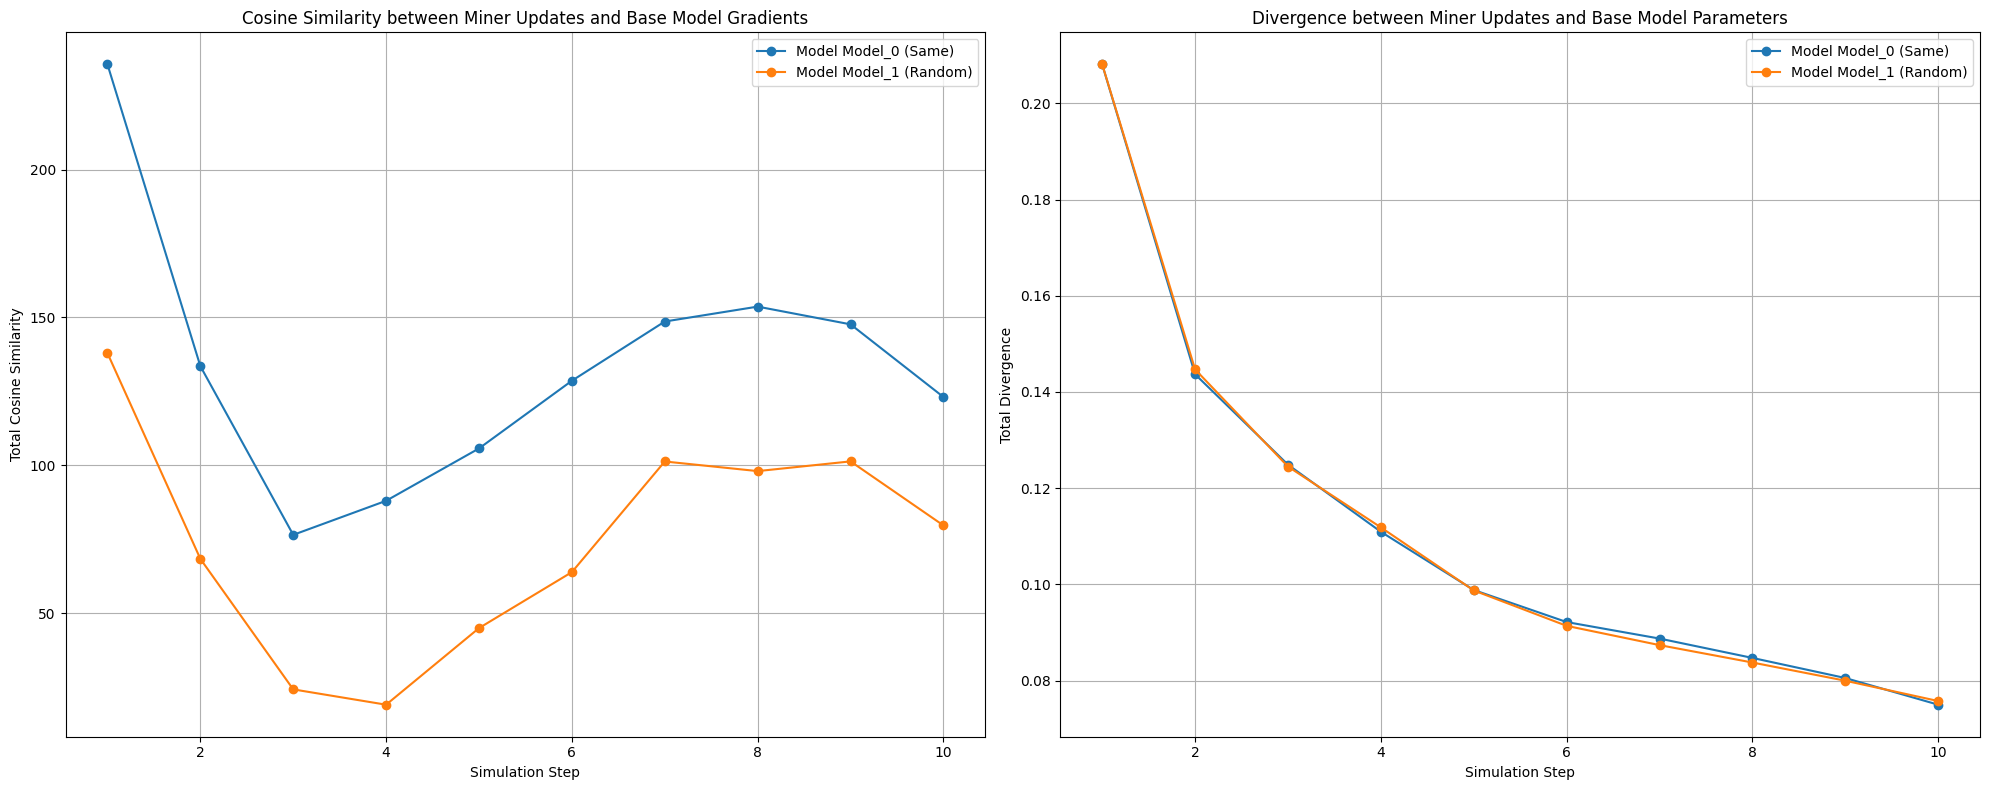

In [8]:
await main( n_steps = 10, n_miners = 2, device = 'cuda:4', compression = 300 )